# **Data importation**

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [ ]:
!chmod 600 kaggle.json

In [ ]:
!kaggle competitions download -c godaddy-microbusiness-density-forecasting

 58% 1.00M/1.74M [00:00<00:00, 2.05MB/s]
100% 1.74M/1.74M [00:00<00:00, 3.10MB/s]


In [ ]:
!unzip \*.zip && rm *.zip

Archive:  godaddy-microbusiness-density-forecasting.zip
  inflating: census_starter.csv      
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


# **Import libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error,mean_absolute_error
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import xgboost
from scipy.stats import spearmanr
import math
from datetime import datetime, timedelta
import plotly.figure_factory as ff
from decimal import ROUND_HALF_UP, Decimal
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# **Main**

In [ ]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
sub = pd.read_csv('/content/sample_submission.csv')
census = pd.read_csv('/content/census_starter.csv')

In [ ]:
print(train.shape)
print(test.shape)
print(census.shape)

(122265, 7)
(25080, 3)
(3142, 26)


In [ ]:
train.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


* columns description : 

+row_id - An ID code for the row.

+cfips - A unique identifier for each county using the Federal Information Processing System. The first two digits correspond to the state FIPS code, while the following 3 represent the county.

+county_name - The written name of the county.

+state_name - The name of the state.

+first_day_of_month - The date of the first day of the month.

+microbusiness_density - Microbusinesses per 100 people over the age of 18 in the given county. This is the target variable. The population figures used to calculate the density are on a two-year lag due to the pace of update provided by the U.S. Census Bureau, which provides the underlying population data annually. 2021 density figures are calculated using 2019 population figures, etc.

+active - The raw count of microbusinesses in the county. Not provided for the test set.

In [ ]:
train.cfips.value_counts()

1001     39
39133    39
39089    39
39091    39
39093    39
         ..
21113    39
21115    39
21117    39
21119    39
56045    39
Name: cfips, Length: 3135, dtype: int64

In [ ]:
test.cfips.value_counts()

1001     8
39133    8
39089    8
39091    8
39093    8
        ..
21113    8
21115    8
21117    8
21119    8
56045    8
Name: cfips, Length: 3135, dtype: int64

In [ ]:
print(train.first_day_of_month.min())
print(train.first_day_of_month.max())
print('+++++++++++++')
print(test.first_day_of_month.min())
print(test.first_day_of_month.max())

2019-08-01
2022-10-01
+++++++++++++
2022-11-01
2023-06-01


+Below we observe that both train and test data have 3135 unique counties (i.e. cfips). In the train data, each county has 39 months of data. And in the test data, each county expects us to predict 8 months. By displaying the min and max dates, we discover that train data ranges from August 2019 thru October 2022 inclusive.

+Time span is too short for making a prediction. As there are only 39 data points for each county, our ML model couldn't learn a lot from historical data.

In [ ]:
census.head()

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,pct_college_2021,pct_foreign_born_2017,pct_foreign_born_2018,pct_foreign_born_2019,pct_foreign_born_2020,pct_foreign_born_2021,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,76.6,78.9,80.6,82.7,85.5,1001,14.5,15.9,16.1,16.7,16.4,2.1,2.0,2.3,2.3,2.1,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,74.5,78.1,81.8,85.1,87.9,1003,20.4,20.7,21.0,20.2,20.6,3.2,3.4,3.7,3.4,3.5,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0
2,57.2,60.4,60.5,64.6,64.6,1005,7.6,7.8,7.6,7.3,6.7,2.7,2.5,2.7,2.6,2.6,0.5,0.3,0.8,1.1,0.8,33368,34186.0,32525,34990.0,36422.0
3,62.0,66.1,69.2,76.1,74.6,1007,8.1,7.6,6.5,7.4,7.9,1.0,1.4,1.5,1.6,1.1,1.2,1.4,1.6,1.7,2.1,43404,45340.0,47542,51721.0,54277.0
4,65.8,68.5,73.0,79.6,81.0,1009,8.7,8.1,8.6,8.9,9.3,4.5,4.4,4.5,4.4,4.5,1.3,1.4,0.9,1.1,0.9,47412,48695.0,49358,48922.0,52830.0


* pctbb[year] - The percentage of households in the county with access to broadband of any type.
* pctcollege[year] - The percent of the population in the county over age 25 with a 4-year college degree.
* pct_foreignborn[year] - The percent of the population in the county born outside of the United States.
* pct_itworkers[year] - The percent of the workforce in the county employed in information related industries.
* median_hhinc[year] - The median household income in the county.

# **Plot census data**

In [ ]:
!pip install plotly-geo pyshp geopandas

In [ ]:
import plotly.figure_factory as ff
import geopandas
import shapely

In [ ]:
fig = ff.create_choropleth(fips=census.cfips, values=census.pct_bb_2017.values)
fig.layout.template = None
fig.show();

# **Data visualization**

* Looking at covid impact

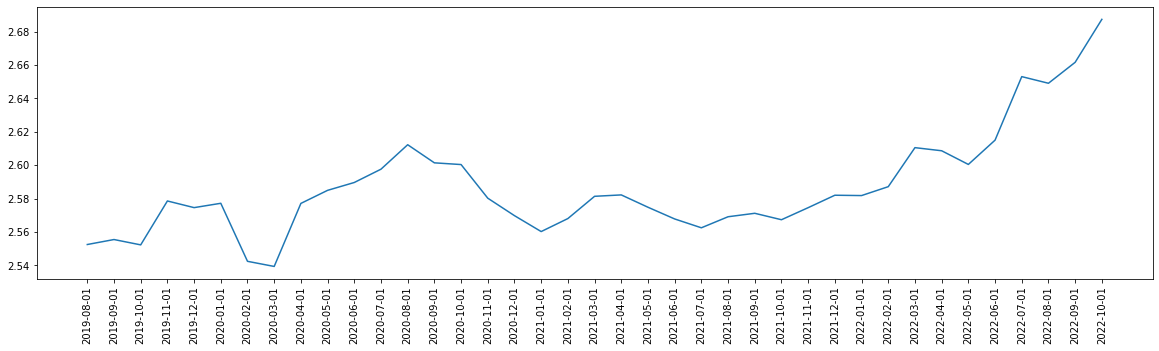

In [ ]:
train_pivoted = train.pivot(index='cfips',columns='first_day_of_month',values='microbusiness_density')
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(train_pivoted.median(axis=0));
plt.xticks(rotation=90);

* On December 31, 2019, China announced the discovery of a cluster of pneumonia cases in Wuhan. We can see that the desnsity has decreased significantly.
* The first American case was reported on January 20, and President Donald Trump declared the U.S. outbreak a public health emergency on January 31
* After the statement of the US President, we can see that the density of micro-enterprises has decreased to the lowest value in recent years (possibly in history). 
* On March 6, 2020, Trump allocated $8.3 billion to fight the outbreak and declared a national emergency on March 13. This action has increased the confidence of americans in their state and its ability to protect them against this epidemic.
* Despite the existence of a wave in June 2020, it did not affect the density which continued to increase until the beginning of August 2020.
* In mid-October, a third wave of cases began; there were more than 200,000 new cases daily. it is the strongest wave from the start of this epidemic. The density decreased until the announcement of the availability of covid19 vaccines in early January 2021.

++ Conclusion : 
* Although we have the explanations of the variations of the density curve, our problem will be more and more difficult because of several reasons: small data size, the data of the duration of the covid will affect our model and degrade its performance, removing the covid period (January 2020 -> December 2020) will further reduce the size of our data.
* With these data, we are not using a very efficient model. We will check this in the rest of the notebook.

In [ ]:
# Removing covid period
#train = train[train.first_day_of_month>'2021-01-01']

In [ ]:
!pip install fasteda

In [ ]:
from fasteda import fast_eda

* Train

DataFrame Head:


,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269


DataFrame Tail:


,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
122262,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100
122263,56045_2022-09-01,56045,Weston County,Wyoming,2022-09-01,1.785395,100
122264,56045_2022-10-01,56045,Weston County,Wyoming,2022-10-01,1.785395,100


----------------------------------------------------------------------------------------------------
Missing values:


,0


----------------------------------------------------------------------------------------------------
Shape of DataFrame:

(122265, 7)

----------------------------------------------------------------------------------------------------
DataFrame Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122265 entries, 0 to 122264
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   row_id                 122265 non-null  object 
 1   cfips                  122265 non-null  int64  
 2   county                 122265 non-null  object 
 3   state                  122265 non-null  object 
 4   first_day_of_month     122265 non-null  object 
 5   microbusiness_density  122265 non-null  float64
 6   active                 122265 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 6.5+ MB
--------------------------------------------------------------------------------------------------

,cfips,microbusiness_density,active
count,122265.000000,122265.000000,122265.000000
mean,30376.037640,3.817671,6442.858218
std,15143.508721,4.991087,33040.012493
min,1001.000000,0.000000,0.000000
25%,18177.000000,1.639344,145.000000
50%,29173.000000,2.586543,488.000000
75%,45077.000000,4.519231,2124.000000
max,56045.000000,284.340030,1167744.000000


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
DataFrame Pairplot:



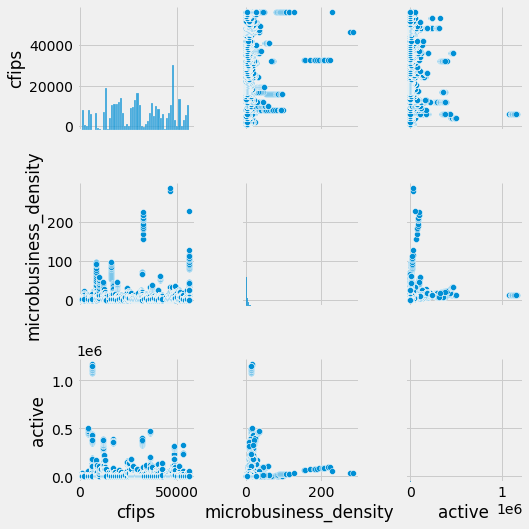

----------------------------------------------------------------------------------------------------
Histogram(s) & Boxplot(s):



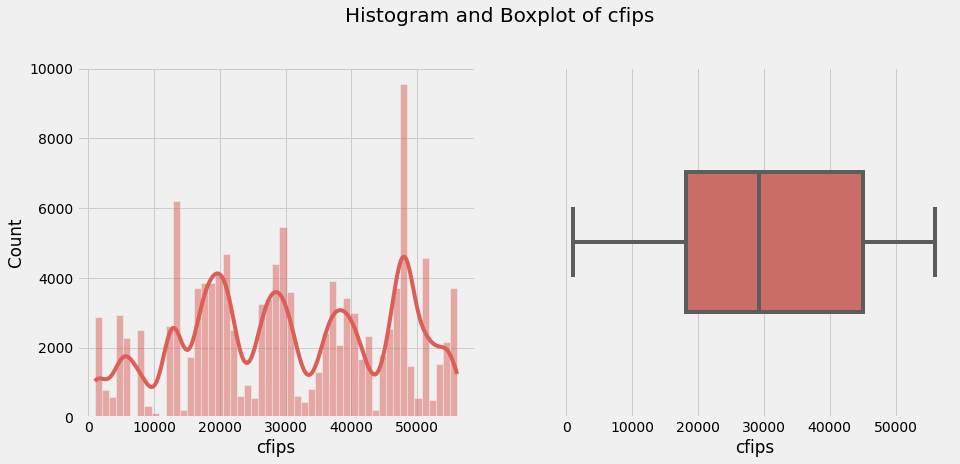

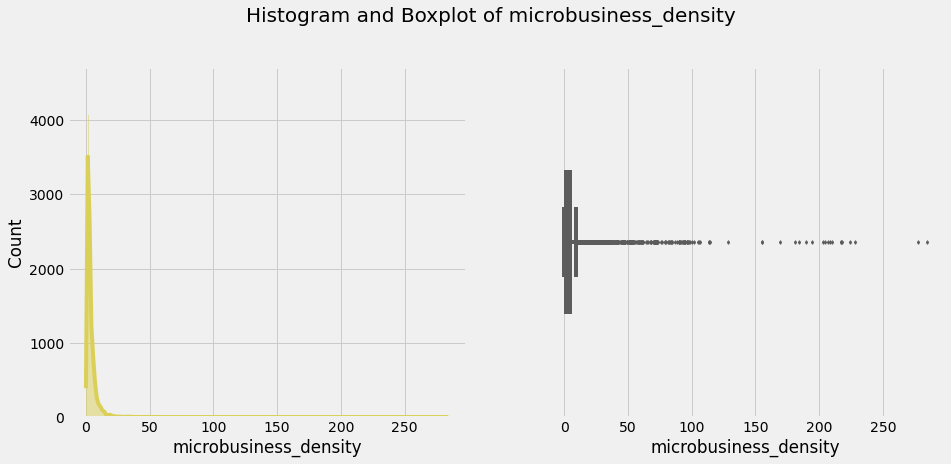

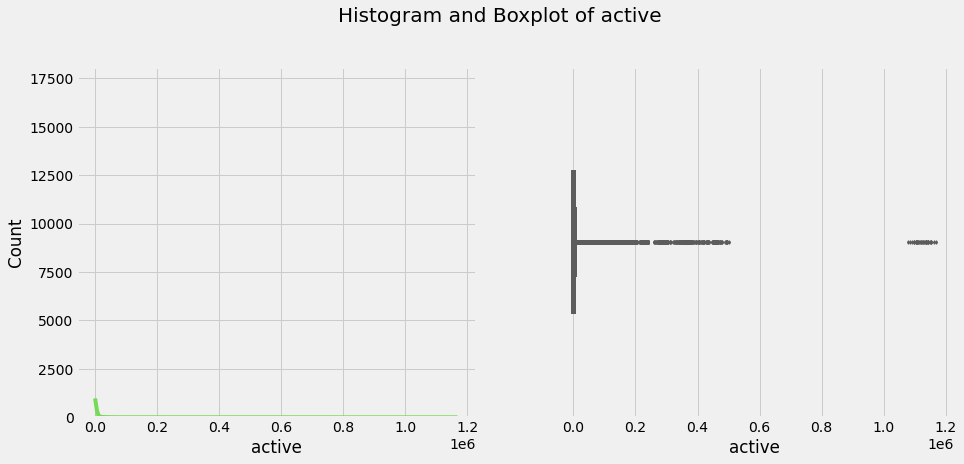

In [ ]:
fast_eda(train, correlation = False)

* Test

DataFrame Head:


,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
1,1003_2022-11-01,1003,2022-11-01
2,1005_2022-11-01,1005,2022-11-01


DataFrame Tail:


,row_id,cfips,first_day_of_month
25077,56041_2023-06-01,56041,2023-06-01
25078,56043_2023-06-01,56043,2023-06-01
25079,56045_2023-06-01,56045,2023-06-01


----------------------------------------------------------------------------------------------------
Missing values:


,0


----------------------------------------------------------------------------------------------------
Shape of DataFrame:

(25080, 3)

----------------------------------------------------------------------------------------------------
DataFrame Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25080 entries, 0 to 25079
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   row_id              25080 non-null  object
 1   cfips               25080 non-null  int64 
 2   first_day_of_month  25080 non-null  object
dtypes: int64(1), object(2)
memory usage: 587.9+ KB
----------------------------------------------------------------------------------------------------
Describe DataFrame:



,cfips
count,25080.000000
mean,30376.037640
std,15143.748704
min,1001.000000
25%,18177.000000
50%,29173.000000
75%,45077.000000
max,56045.000000


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
DataFrame Pairplot:



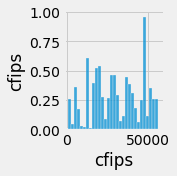

----------------------------------------------------------------------------------------------------
Histogram(s) & Boxplot(s):



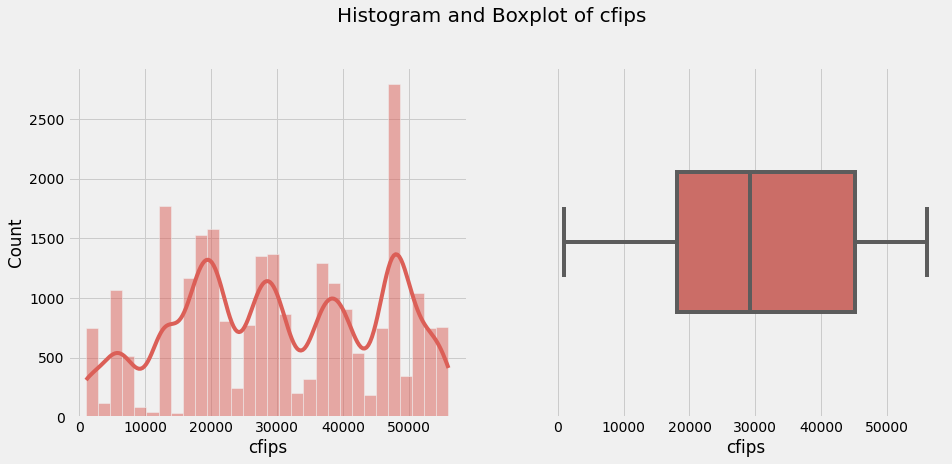

----------------------------------------------------------------------------------------------------
Countplot(s):



AttributeError: ignored

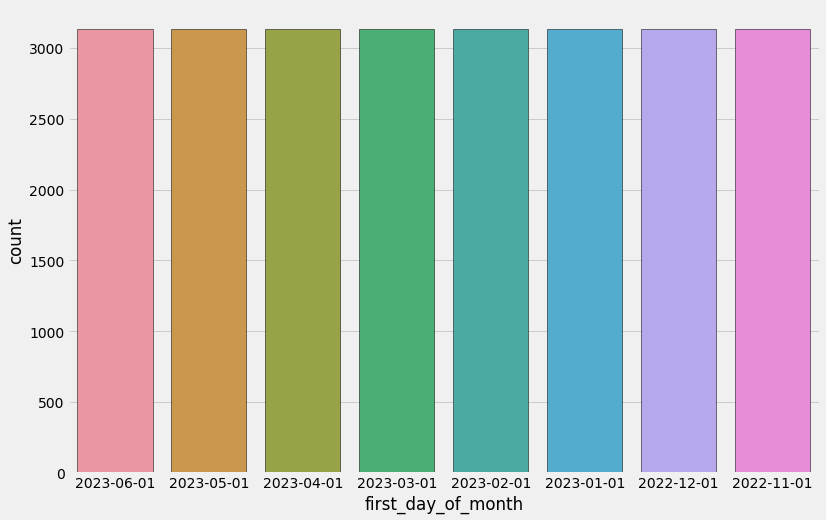

In [ ]:
fast_eda(test, correlation = False)

* Census

DataFrame Head:


,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,pct_college_2021,pct_foreign_born_2017,pct_foreign_born_2018,pct_foreign_born_2019,pct_foreign_born_2020,pct_foreign_born_2021,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,76.6,78.9,80.6,82.7,85.5,1001,14.5,15.9,16.1,16.7,16.4,2.1,2.0,2.3,2.3,2.1,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,74.5,78.1,81.8,85.1,87.9,1003,20.4,20.7,21.0,20.2,20.6,3.2,3.4,3.7,3.4,3.5,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0
2,57.2,60.4,60.5,64.6,64.6,1005,7.6,7.8,7.6,7.3,6.7,2.7,2.5,2.7,2.6,2.6,0.5,0.3,0.8,1.1,0.8,33368,34186.0,32525,34990.0,36422.0


DataFrame Tail:


,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,pct_college_2021,pct_foreign_born_2017,pct_foreign_born_2018,pct_foreign_born_2019,pct_foreign_born_2020,pct_foreign_born_2021,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
3139,83.8,88.2,89.5,91.4,90.6,56041,11.9,10.5,11.1,12.6,12.3,2.9,3.1,2.9,2.9,2.9,1.2,1.2,1.4,1.7,0.9,54672,58235.0,63403,72458.0,75106.0
3140,76.4,78.3,78.2,82.8,85.4,56043,15.4,15.0,15.4,15.0,17.2,2.3,1.4,1.6,2.2,1.0,1.3,1.0,0.9,0.9,1.1,51362,53426.0,54158,57306.0,62271.0
3141,71.1,73.3,76.8,79.7,81.3,56045,14.1,13.5,13.4,12.7,13.9,3.8,4.1,1.7,2.3,1.6,0.6,0.6,0.0,0.0,0.0,59605,52867.0,57031,53333.0,65566.0


----------------------------------------------------------------------------------------------------
Missing values:


,0
pct_bb_2020,1
pct_bb_2021,1
pct_college_2020,1
pct_college_2021,1
pct_foreign_born_2020,1
pct_foreign_born_2021,1
pct_it_workers_2018,1
pct_it_workers_2020,1
pct_it_workers_2021,1
median_hh_inc_2018,1


----------------------------------------------------------------------------------------------------
MSNO Matrix:



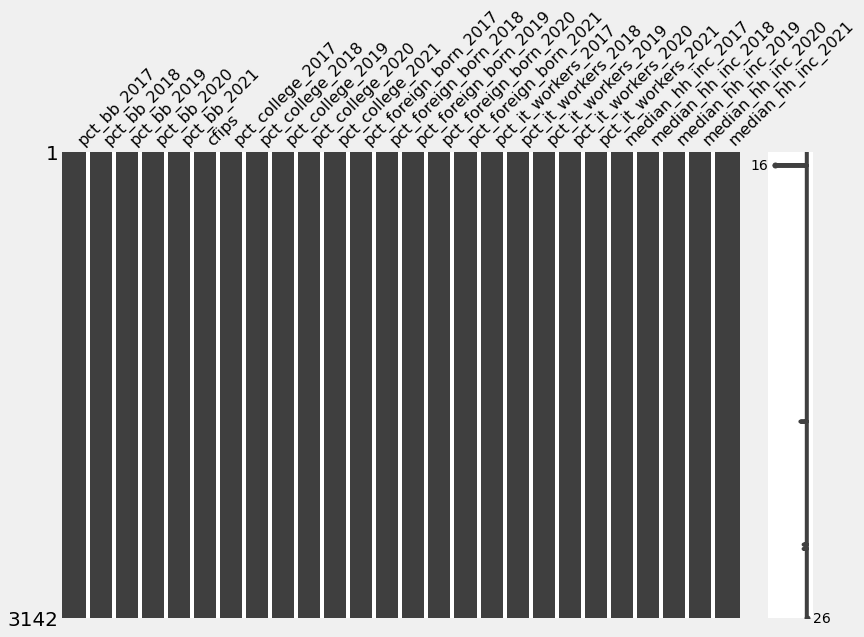

----------------------------------------------------------------------------------------------------
Shape of DataFrame:

(3142, 26)

----------------------------------------------------------------------------------------------------
DataFrame Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   pct_bb_2017            3142 non-null   float64
 1   pct_bb_2018            3142 non-null   float64
 2   pct_bb_2019            3142 non-null   float64
 3   pct_bb_2020            3141 non-null   float64
 4   pct_bb_2021            3141 non-null   float64
 5   cfips                  3142 non-null   int64  
 6   pct_college_2017       3142 non-null   float64
 7   pct_college_2018       3142 non-null   float64
 8   pct_college_2019       3142 non-null   float64
 9   pct_college_2020       3141 non-null   float64
 10  pct_college_

,count,mean,std,min,25%,50%,75%,max
pct_bb_2017,3142.000000,69.920401,9.702052,24.500000,64.200000,70.700000,76.400000,94.600000
pct_bb_2018,3142.000000,72.690866,9.255863,25.700000,67.425000,73.600000,78.800000,95.500000
pct_bb_2019,3142.000000,75.398600,8.846665,34.800000,70.500000,76.450000,81.400000,96.000000
pct_bb_2020,3141.000000,78.543298,8.250864,33.300000,74.100000,79.600000,84.100000,97.100000
pct_bb_2021,3141.000000,80.539096,7.889931,37.000000,76.400000,81.700000,85.900000,97.600000
cfips,3142.000000,30383.649268,15162.508374,1001.000000,18177.500000,29176.000000,45080.500000,56045.000000
pct_college_2017,3142.000000,13.813399,5.586649,2.400000,9.700000,12.800000,16.800000,43.700000
pct_college_2018,3142.000000,14.005379,5.630199,0.000000,9.900000,13.000000,17.100000,48.000000
pct_college_2019,3142.000000,14.240452,5.689780,0.000000,10.100000,13.250000,17.300000,45.400000
pct_college_2020,3141.000000,14.631328,5.776940,0.000000,10.500000,13.600000,17.900000,43.000000


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Histogram(s) & Boxplot(s):



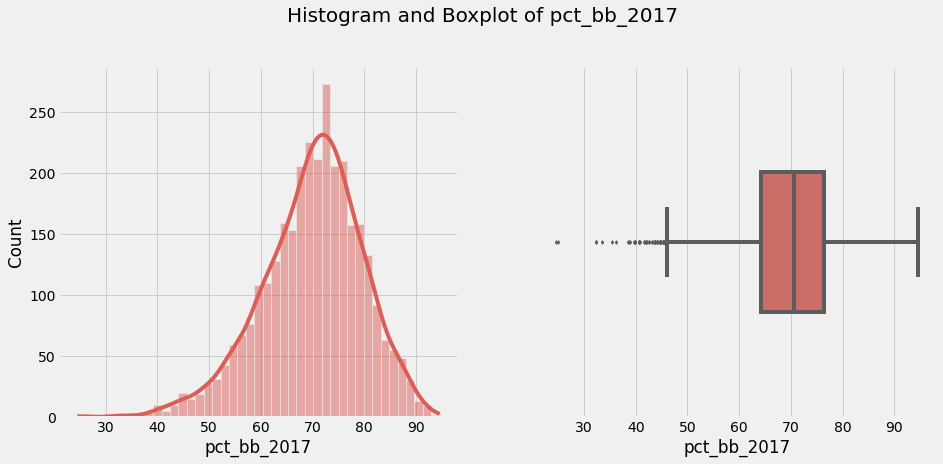

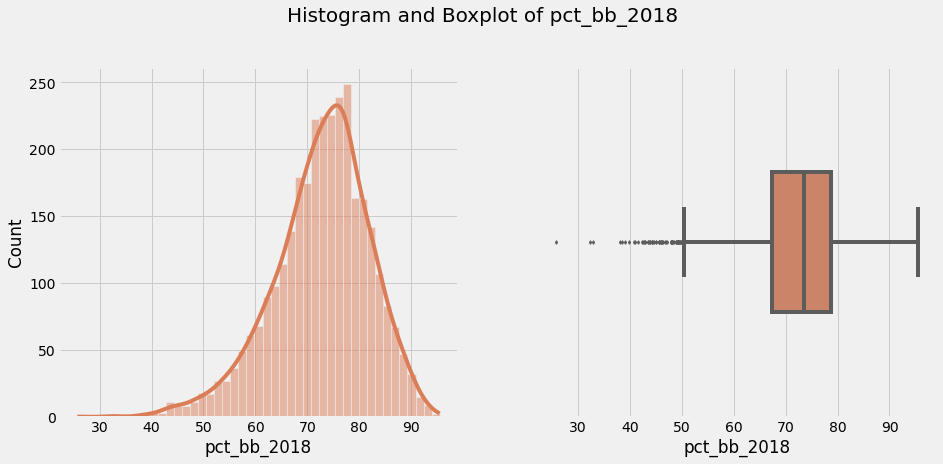

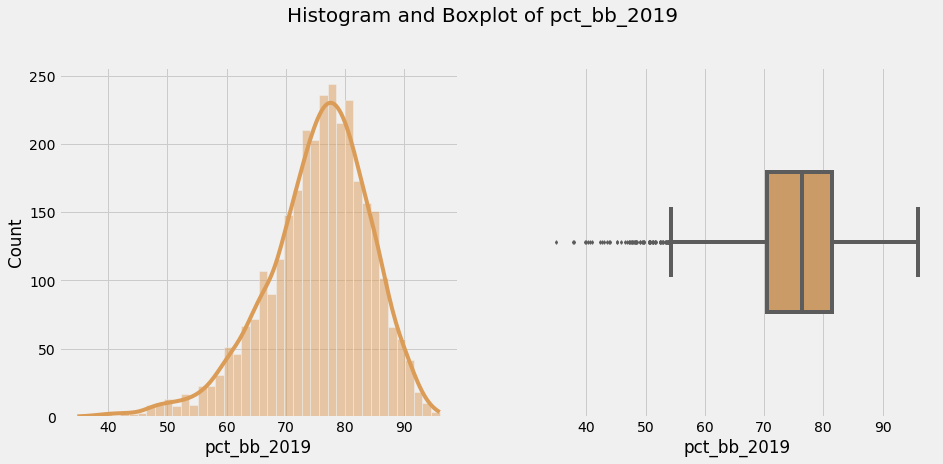

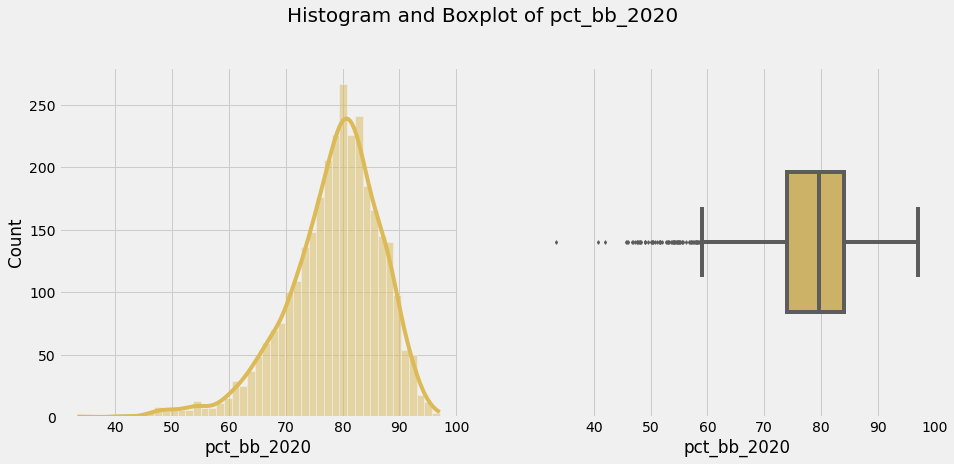

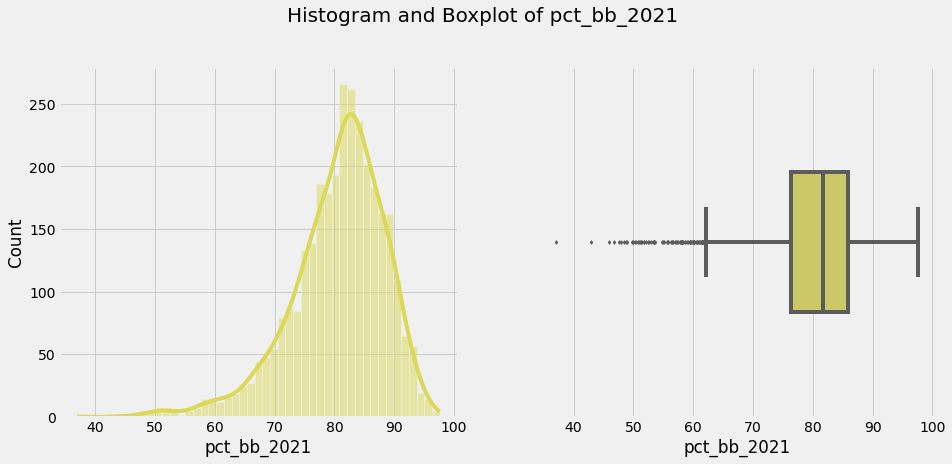

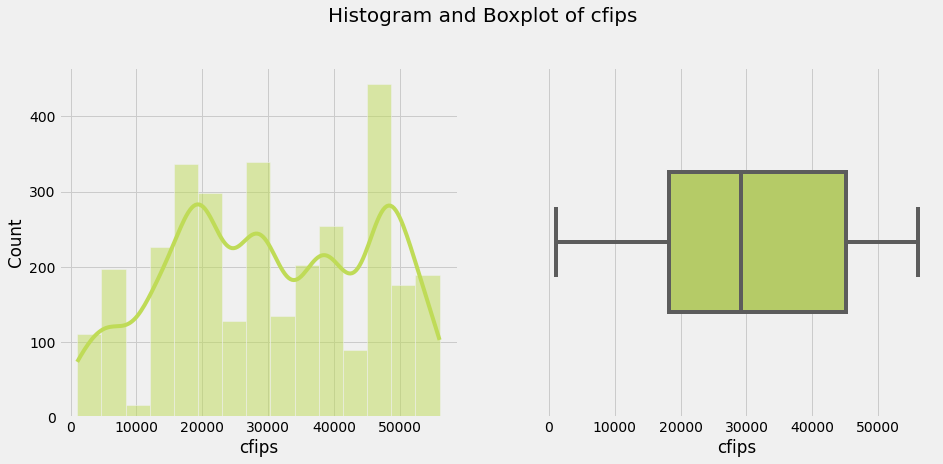

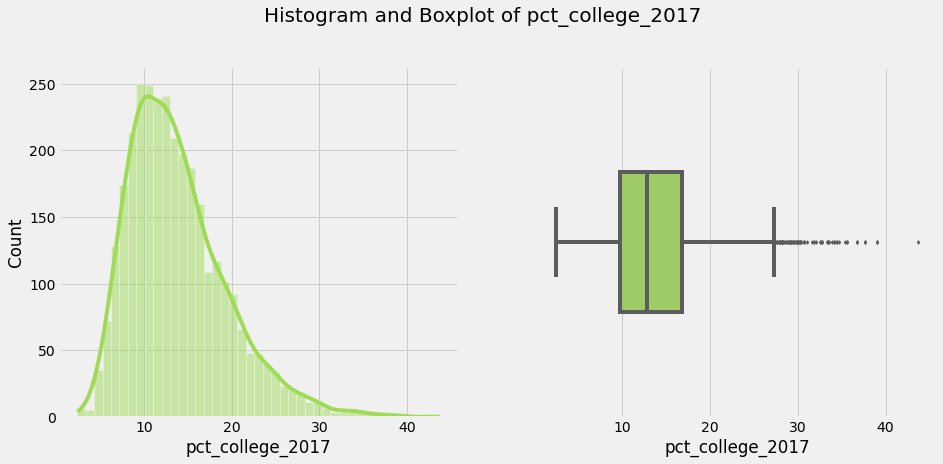

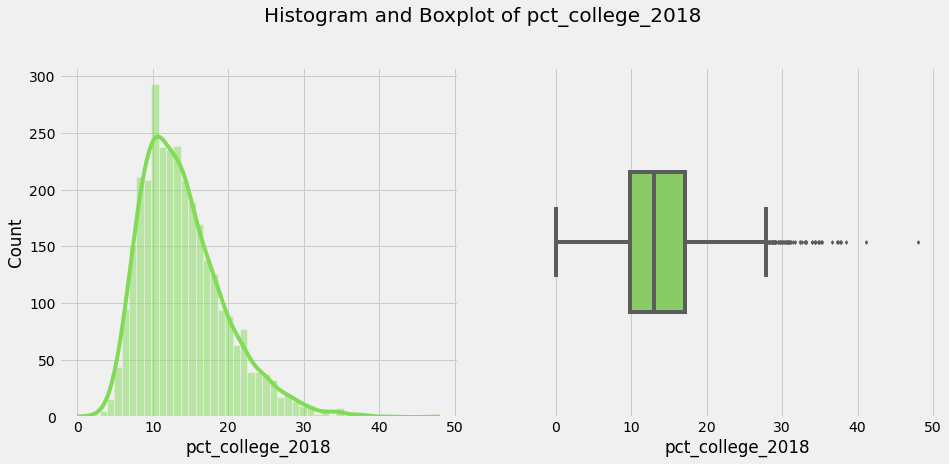

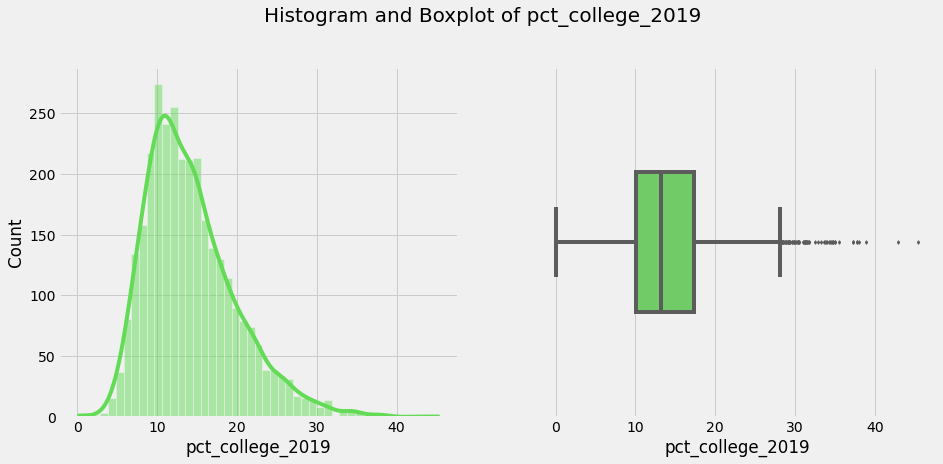

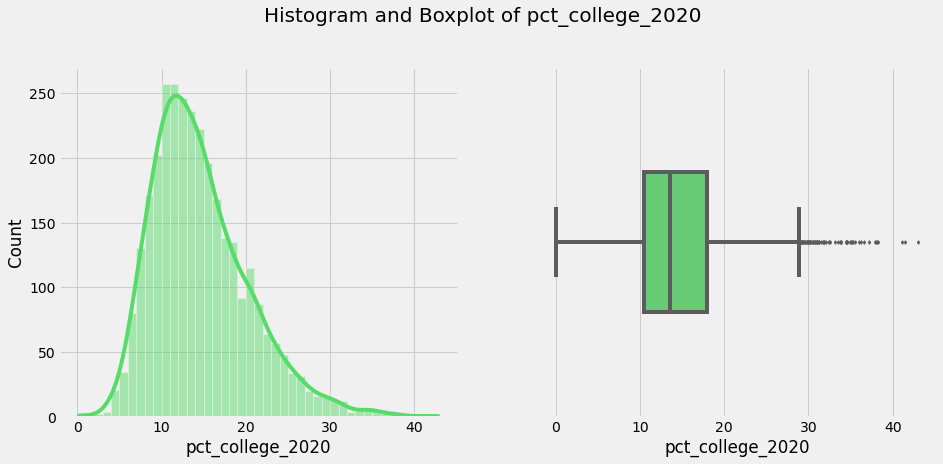

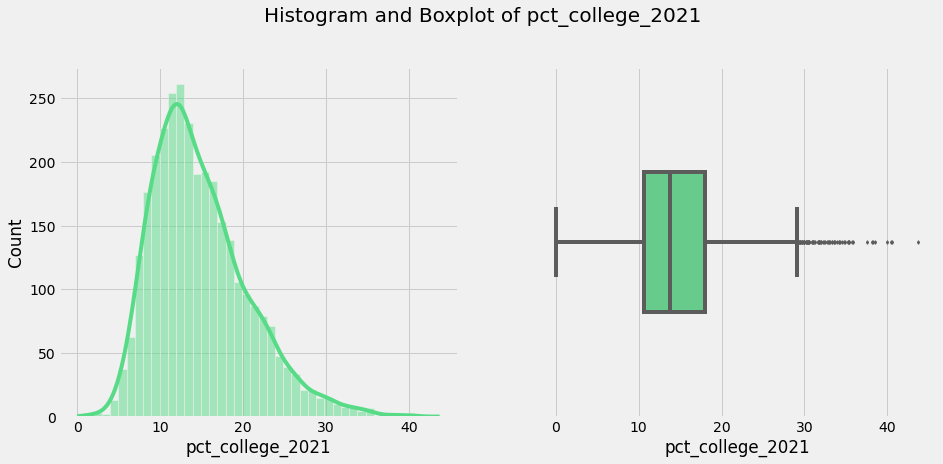

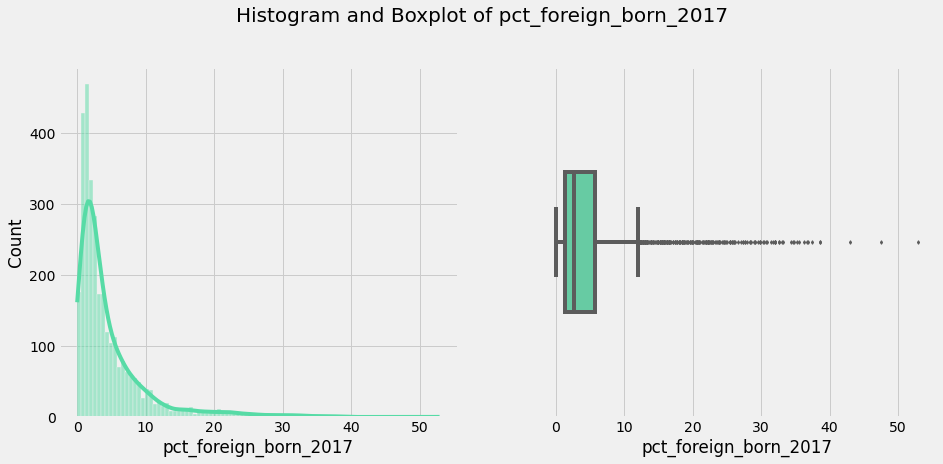

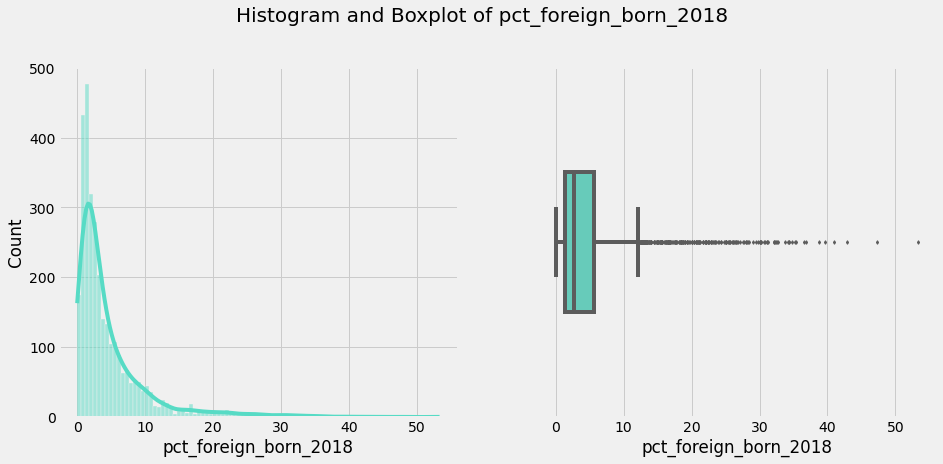

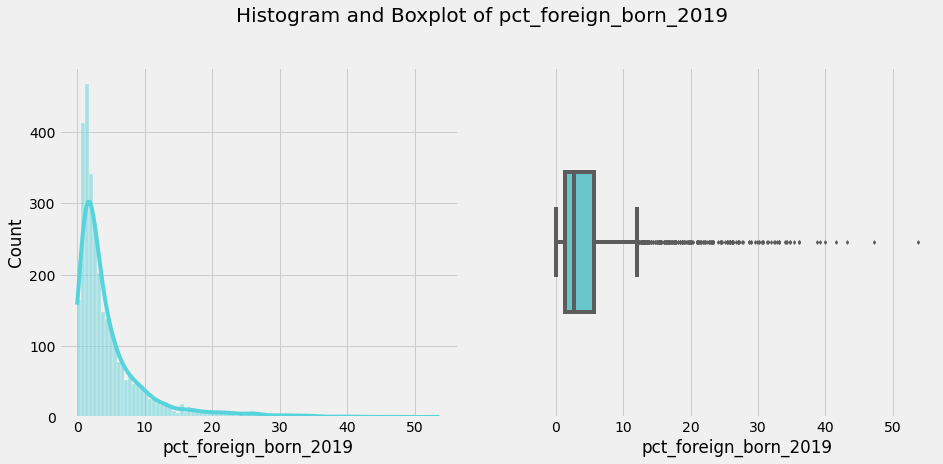

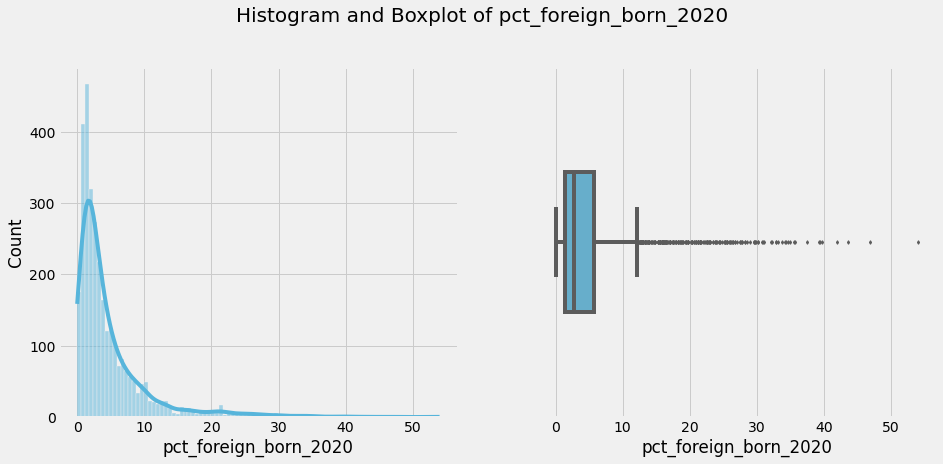

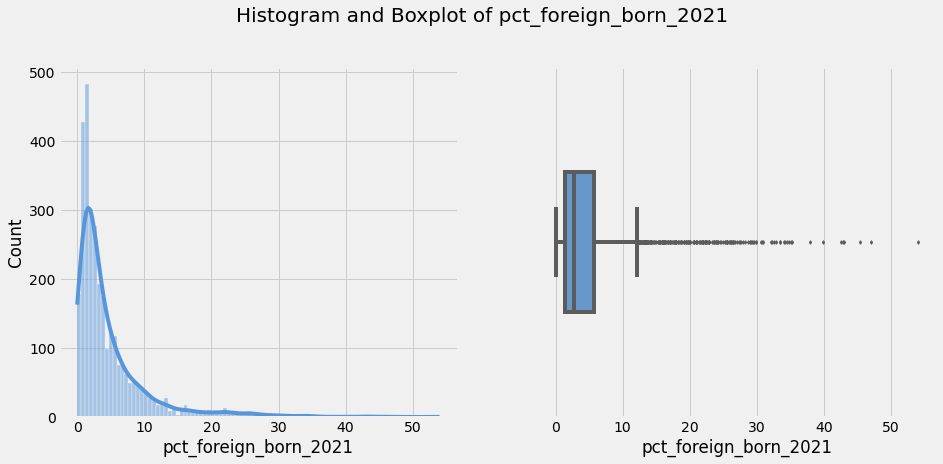

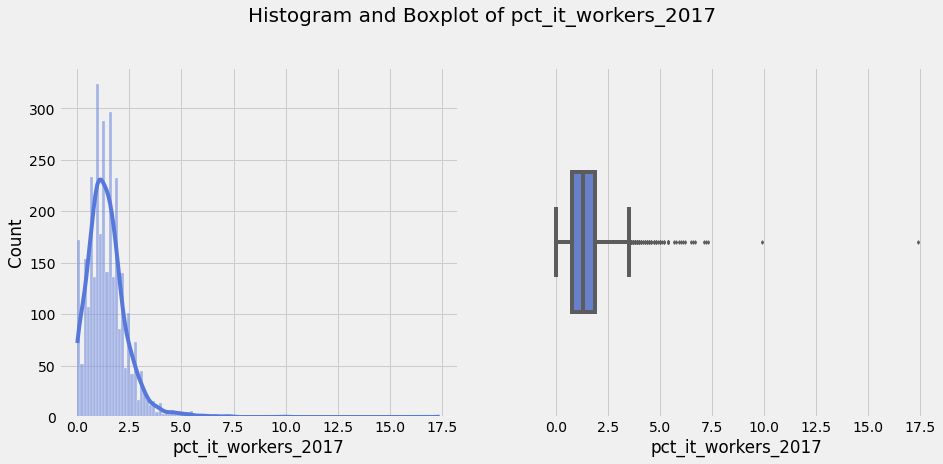

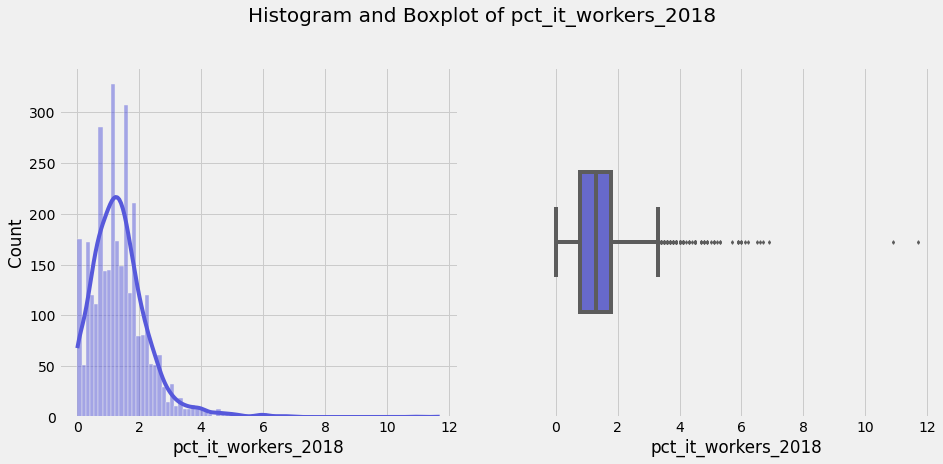

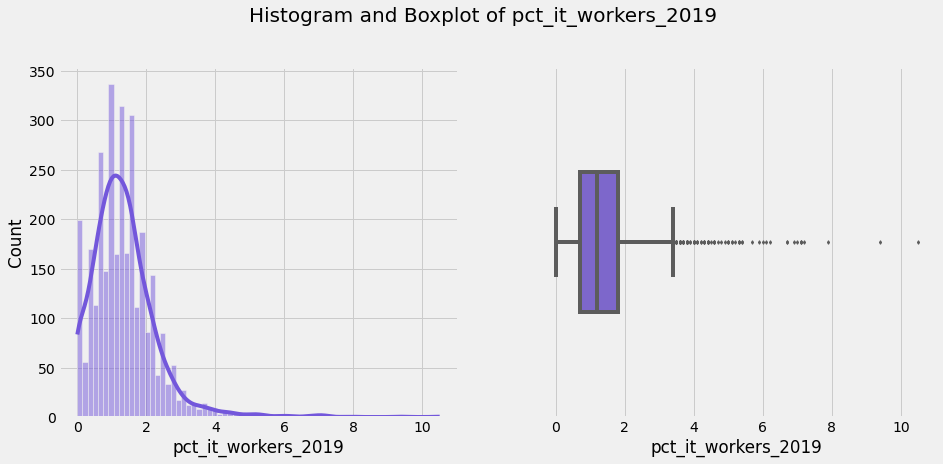

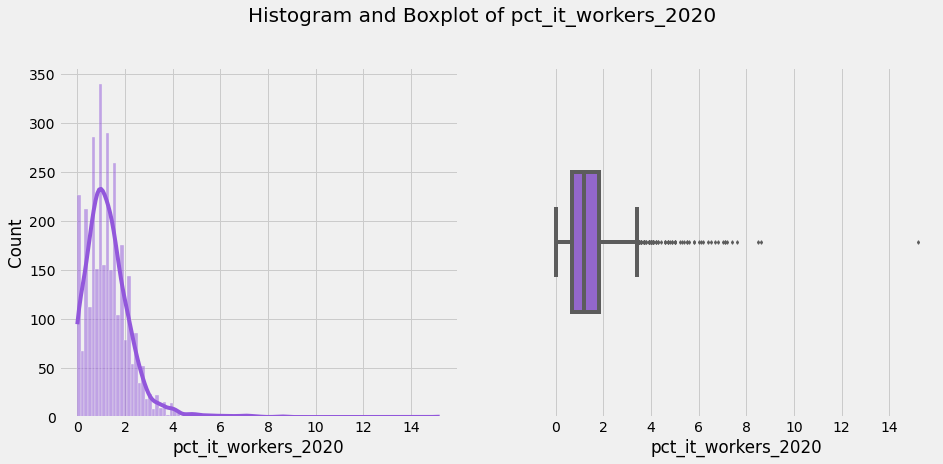

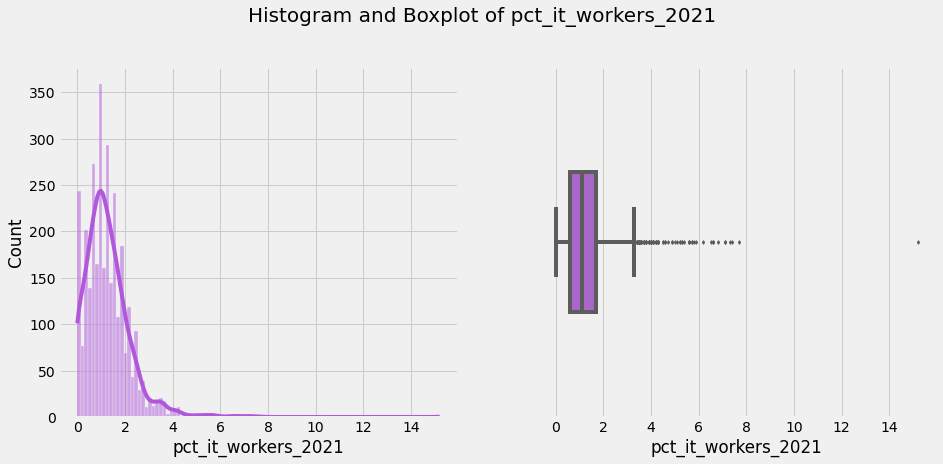

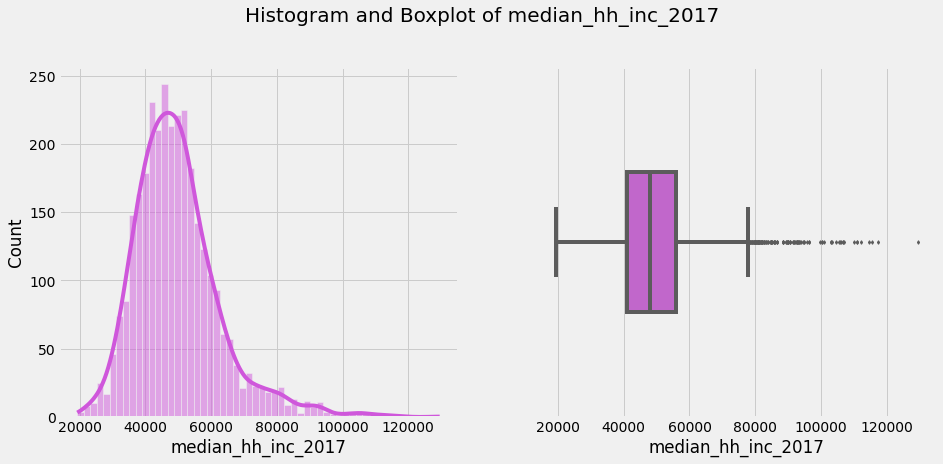

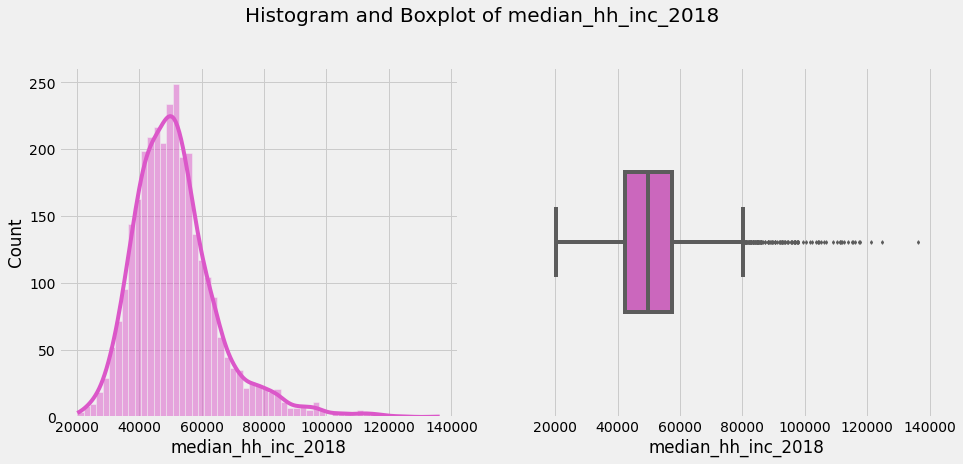

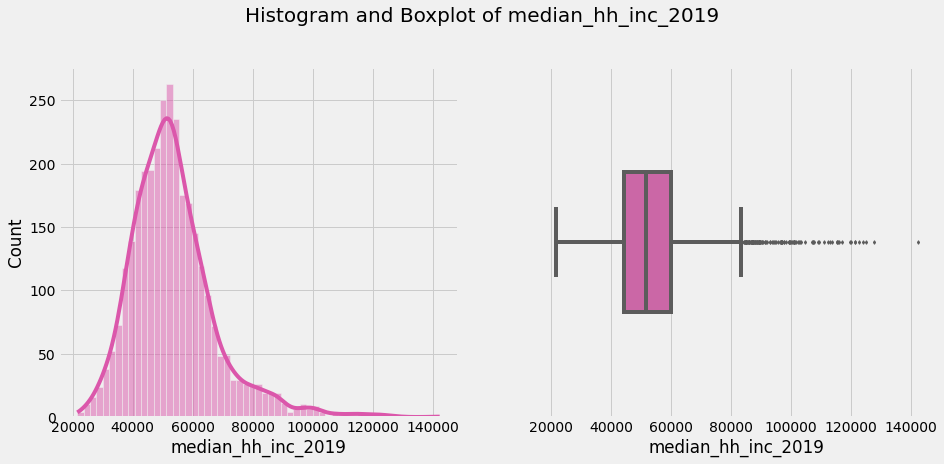

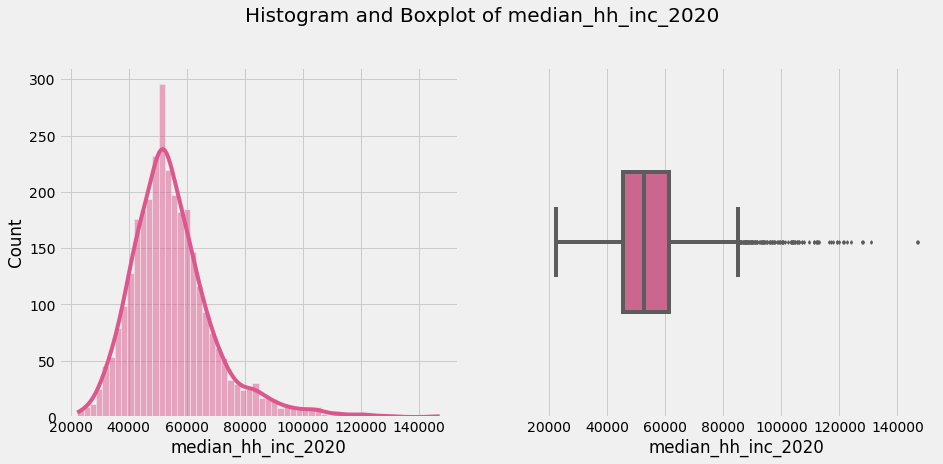

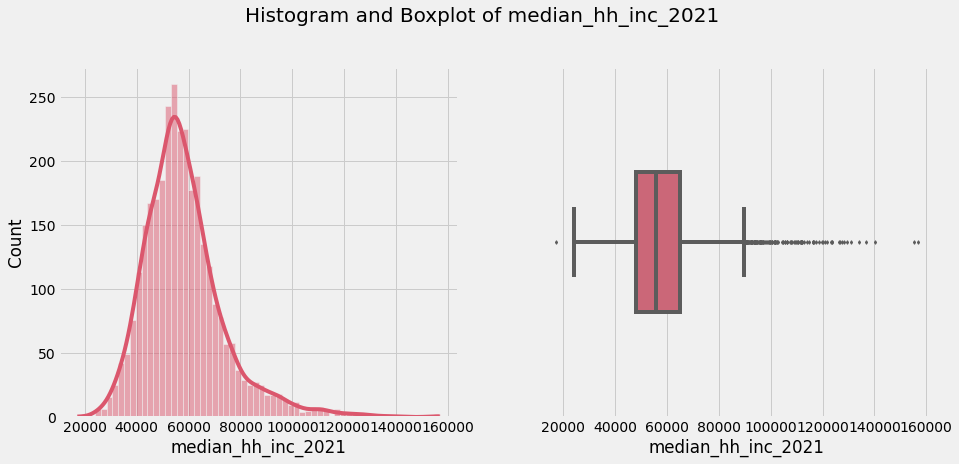

In [ ]:
fast_eda(census, correlation = False)

# **Feature engineering**

+Census data contain data from 2017 to 2021. We cannot merge it directly because we have data from 2019 to 2023 so for example in 2019 we cannot use data of 2021 in our features. So we must take into consideration this remarque.

==>Since the data for the year 2022 does not yet exist in census data, we will not use test data (submission data) for the moment.

==>As census data starts from 2017 and train data starts from 2019, for each scenario (database row) we will use census data from the last two years.

====> we will work only on train and census data

* Concatenate train and census data

In [ ]:
train.head(2)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198


In [ ]:
census.head(2)

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,pct_college_2021,pct_foreign_born_2017,pct_foreign_born_2018,pct_foreign_born_2019,pct_foreign_born_2020,pct_foreign_born_2021,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,76.6,78.9,80.6,82.7,85.5,1001,14.5,15.9,16.1,16.7,16.4,2.1,2.0,2.3,2.3,2.1,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,74.5,78.1,81.8,85.1,87.9,1003,20.4,20.7,21.0,20.2,20.6,3.2,3.4,3.7,3.4,3.5,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0


In [ ]:
print(len(list(census.cfips.unique())))
print(len(census))

3142
3142


In [ ]:
census_cols = list(census.columns)
census_cols = [elt[0:len(elt)-5] for elt in census_cols if '_' in elt]
census_cols = list(set(census_cols))
print(census_cols)

['median_hh_inc', 'pct_foreign_born', 'pct_it_workers', 'pct_college', 'pct_bb']


* **Create column for these variable for the last year and the year before last**

In [ ]:
for col in census_cols:
  col1_name = col+'_last_year'
  col2_name = col+'_the_year_before_last'
  train[col1_name] = 0
  train[col2_name] = 0

In [ ]:
train.head(2)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,median_hh_inc_last_year,median_hh_inc_the_year_before_last,pct_foreign_born_last_year,pct_foreign_born_the_year_before_last,pct_it_workers_last_year,pct_it_workers_the_year_before_last,pct_college_last_year,pct_college_the_year_before_last,pct_bb_last_year,pct_bb_the_year_before_last
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,0,0,0,0,0,0,0,0,0,0
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,0,0,0,0,0,0,0,0,0,0


In [ ]:
def get_year(x):
  return x[0:4]
train['year'] = train['first_day_of_month'].apply(get_year)

In [ ]:
for k in range(len(train)):
  current_year = train.year.iloc[k]
  current_cfips = train.cfips.iloc[k]
  current_census_data = census[census['cfips']==current_cfips]
  for col in census_cols:
    train[col+'_last_year'].iloc[k] = current_census_data[col+'_'+str(int(current_year)-1)].iloc[0]
    train[col+'_the_year_before_last'].iloc[k] = current_census_data[col+'_'+str(int(current_year)-2)].iloc[0]

In [ ]:
train.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,median_hh_inc_last_year,median_hh_inc_the_year_before_last,pct_foreign_born_last_year,pct_foreign_born_the_year_before_last,pct_it_workers_last_year,pct_it_workers_the_year_before_last,pct_college_last_year,pct_college_the_year_before_last,pct_bb_last_year,pct_bb_the_year_before_last,year
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,58786.0,55317.0,2.0,2.1,1.1,1.3,15.9,14.5,78.9,76.6,2019
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,58786.0,55317.0,2.0,2.1,1.1,1.3,15.9,14.5,78.9,76.6,2019
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,58786.0,55317.0,2.0,2.1,1.1,1.3,15.9,14.5,78.9,76.6,2019
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,58786.0,55317.0,2.0,2.1,1.1,1.3,15.9,14.5,78.9,76.6,2019
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,58786.0,55317.0,2.0,2.1,1.1,1.3,15.9,14.5,78.9,76.6,2019


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122265 entries, 0 to 122264
Data columns (total 18 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   row_id                                 122265 non-null  object 
 1   cfips                                  122265 non-null  int64  
 2   county                                 122265 non-null  object 
 3   state                                  122265 non-null  object 
 4   first_day_of_month                     122265 non-null  object 
 5   microbusiness_density                  122265 non-null  float64
 6   active                                 122265 non-null  int64  
 7   median_hh_inc_last_year                122238 non-null  float64
 8   median_hh_inc_the_year_before_last     122243 non-null  float64
 9   pct_foreign_born_last_year             122265 non-null  float64
 10  pct_foreign_born_the_year_before_last  122265 non-null  

In [ ]:
#train.to_csv('train_with_census.csv',index=False)
train = pd.read_csv('/content/train_with_census.csv')

+I know that i must optimize this work but for the moment in need to accelerate the coding process.

In [ ]:
train['median_hh_inc_last_year'].fillna(train['median_hh_inc_last_year'].mean(), inplace = True)
train['median_hh_inc_the_year_before_last'].fillna(train['median_hh_inc_the_year_before_last'].mean(), inplace = True)
train['pct_it_workers_the_year_before_last'].fillna(train['pct_it_workers_the_year_before_last'].mean(), inplace = True)
train['pct_it_workers_last_year'].fillna(train['pct_it_workers_last_year'].mean(), inplace = True)

* Extract date features

In [ ]:
train['first_day_of_month'] = pd.to_datetime(train["first_day_of_month"])
train['month'] = train["first_day_of_month"].dt.month
#train['day'] = train["first_day_of_month"].dt.day (because already = 1)
train['dayofweek'] = train["first_day_of_month"].dt.dayofweek
def is_weekend(x):
  if x>=5:
    return 1
  else:
    return 0
train['weekend'] = train['dayofweek'].apply(is_weekend)

In [ ]:
!pip install holidays

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import holidays
us_holidays = holidays.country_holidays('US')  
def is_holiday(x):
  #x = x.strftime("%m/%d/%Y")
  if x in us_holidays:
    return 1
  else:
    return 0
train['holiday'] = train['first_day_of_month'].apply(is_holiday)

In [ ]:
train['weekofyear'] = train['first_day_of_month'].dt.weekofyear
train["contry_code"] = train["cfips"] // 100
train["state_code"] = train["cfips"] % 100

In [ ]:
def get_season(x):
  if ((x>=12)|(x<=2)):
    return 1
  if ((x>=3)&(x<=5)):
    return 3
  if ((x>=6)&(x<=8)):
    return 3
  else:
    return 4
train['season'] = train['month'].apply(get_season)

In [ ]:
train.head(3)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,median_hh_inc_last_year,median_hh_inc_the_year_before_last,pct_foreign_born_last_year,pct_foreign_born_the_year_before_last,pct_it_workers_last_year,pct_it_workers_the_year_before_last,pct_college_last_year,pct_college_the_year_before_last,pct_bb_last_year,pct_bb_the_year_before_last,year,month,dayofweek,weekend,holiday,weekofyear,contry_code,state_code,season
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,58786.0,55317.0,2.0,2.1,1.1,1.3,15.9,14.5,78.9,76.6,2019,8,3,0,0,31,10,1,3
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,58786.0,55317.0,2.0,2.1,1.1,1.3,15.9,14.5,78.9,76.6,2019,9,6,1,0,35,10,1,4
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,58786.0,55317.0,2.0,2.1,1.1,1.3,15.9,14.5,78.9,76.6,2019,10,1,0,0,40,10,1,4


* Microbusiness_density over time seperated by state

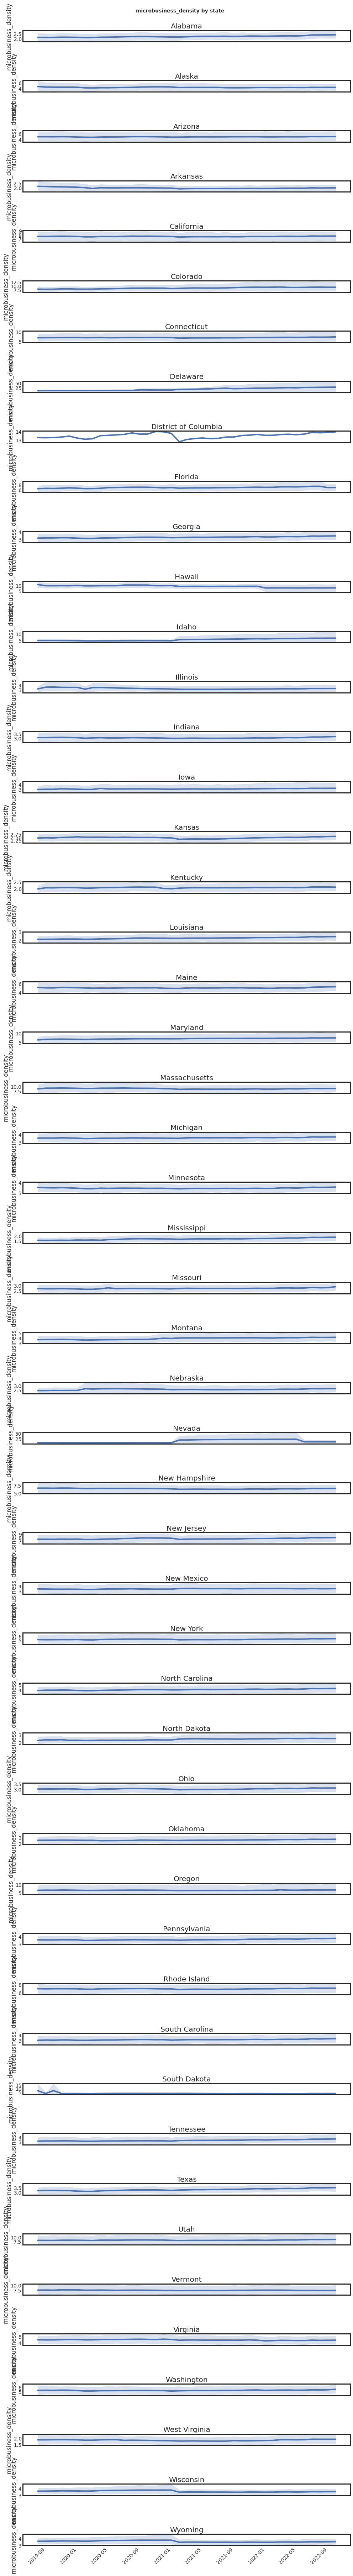

In [ ]:
import seaborn as sn; sn.set_style("white")

fig = plt.figure(figsize=(14,100))
x = 1
for unique_state in train["state"].unique()[:-1]:
    ax = fig.add_subplot(51,1,x)
    sn.lineplot(x=train.loc[train["state"] == unique_state, "first_day_of_month"], y=train.loc[train["state"] == unique_state,"microbusiness_density"], color="#4C72B0")
    plt.title(unique_state)
    plt.xlabel("")
    plt.tick_params(
        axis='x',          
        which='both',      
        bottom=False,      
        top=False,         
        labelbottom=False)
    x+=1
ax = fig.add_subplot(51,1,x)
sn.lineplot(x=train.loc[train["state"] == unique_state, "first_day_of_month"], y=train.loc[train["state"] == unique_state,"microbusiness_density"], color="#4C72B0")
plt.title(train["state"].unique()[-1])
plt.xticks(rotation=45, ha='right')
plt.xlabel("")
ttl = plt.suptitle("microbusiness_density by state", fontsize=14, fontweight="bold")
ttl.set_position([.51, 1.00])
plt.tight_layout()
plt.show()

* Correlation between microbusiness_density and date seperated by state

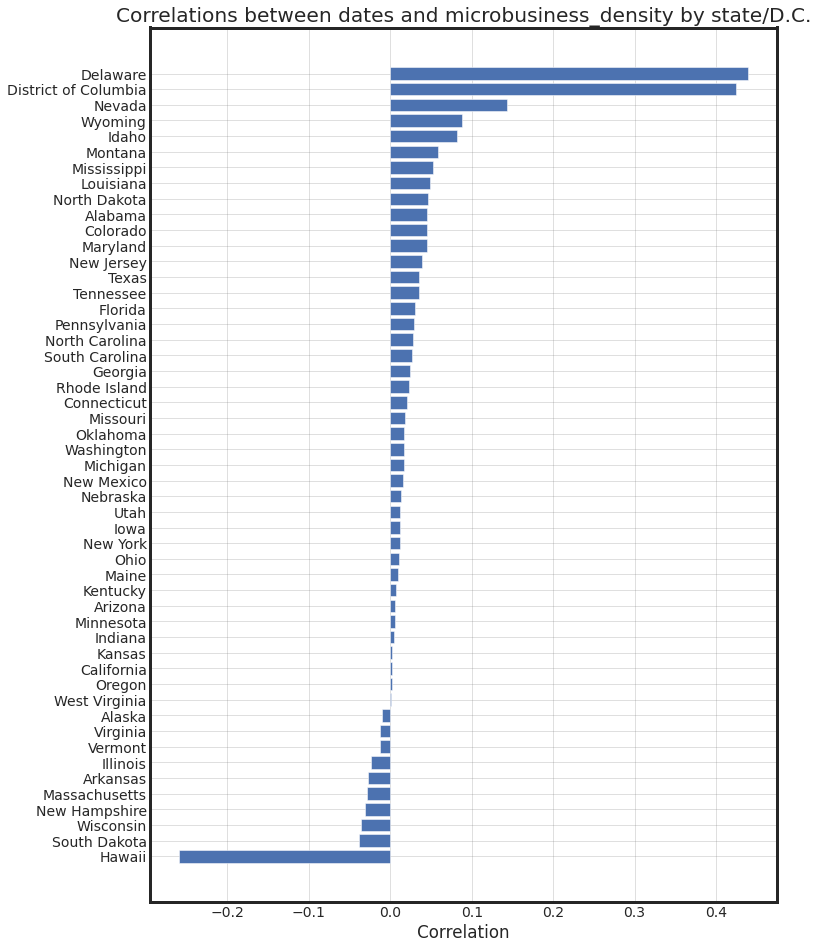

In [ ]:
days_conversion = list()
for date in pd.to_datetime(train["first_day_of_month"]):
    days_conversion.append((date - pd.to_datetime(date.today())).days)

temp = pd.concat([pd.Series(days_conversion),
                  train["state"],
                  train["microbusiness_density"]],
                 axis=1)
temp.columns = ["days_since", "state", "microbusiness_density"]

corr_by_state = list()
for state in temp["state"].unique():
    corr_by_state.append(temp.loc[temp["state"]==state, ["days_since", "microbusiness_density"]].corr().values[0][1])
corr_by_state = pd.Series(corr_by_state, index=temp["state"].unique())

fig = plt.figure(figsize=(10,15))
plt.barh(width=corr_by_state.sort_values().values,
         y=corr_by_state.sort_values().index,
        color="#4C72B0")
plt.grid(True, color = "grey", linewidth = "0.5", alpha=0.5)
plt.title("Correlations between dates and microbusiness_density by state/D.C.")
plt.xlabel("Correlation")
plt.show()

* **Time series features**

++ Create function for MA and EWM.

++ SMA and EMA are both commonly-used trend indicators. SMA gives equal weight to all data points,  while EMA applies more weight to recent data points. 

In [ ]:
def moving_average(df,i, n):
    MA = pd.Series(df[i].rolling(n, min_periods=n).mean(), name = 'MA_' + str(n))
    df = df.join(MA)
    return df

def weighted_moving_average(df,i, n):
    EMA = pd.Series(df[i].ewm(span=n, adjust=False, min_periods=n).mean(), name = 'EMA_' + str(n))
    df = df.join(EMA)
    return df

# create Moving Average variable.
train = moving_average(train, 'microbusiness_density', 3)
train = moving_average(train, 'microbusiness_density', 6)

# actually it's Exponential Moving Average. 
train = weighted_moving_average(train, 'microbusiness_density', 3)
train = weighted_moving_average(train, 'microbusiness_density', 6)

* Generate lagged data , lag(1) means previous (one-month) month's microbusiness density.

In [ ]:
def lag_feature(df):
    for lag in range(1, 6):
        df[f'lag_density_{lag}'] = df.groupby('cfips')['microbusiness_density'].shift(lag)
        df[f'lag_density_{lag}'] = df.groupby('cfips')[f'lag_density_{lag}'].bfill()  
    return df

train = lag_feature(train)

* we should consider 'national-wide' and 'state-wide' factors, like average micro-business density in each state on each month or national average micro-business density each month

In [ ]:
train['national_avg'] = train.groupby(['year','month'])['microbusiness_density'].transform('mean')
train['state_avg'] = train.groupby(['state','year','month'])['microbusiness_density'].transform('mean')

In [ ]:
train['lastactive'] = train.groupby('cfips')['active'].transform('last')

In [ ]:
print(train.shape)
train.head()

(122265, 38)


,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,median_hh_inc_last_year,median_hh_inc_the_year_before_last,pct_foreign_born_last_year,pct_foreign_born_the_year_before_last,pct_it_workers_last_year,pct_it_workers_the_year_before_last,pct_college_last_year,pct_college_the_year_before_last,pct_bb_last_year,pct_bb_the_year_before_last,year,month,dayofweek,weekend,holiday,weekofyear,contry_code,state_code,season,MA_3,MA_6,EMA_3,EMA_6,lag_density_1,lag_density_2,lag_density_3,lag_density_4,lag_density_5,national_avg,state_avg,lastactive
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,58786.0,55317.0,2.0,2.1,1.1,1.3,15.9,14.5,78.9,76.6,2019,8,3,0,0,31,10,1,3,NaN,NaN,NaN,NaN,3.007682,3.007682,3.007682,3.007682,3.007682,3.749621,2.132323,1472
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,58786.0,55317.0,2.0,2.1,1.1,1.3,15.9,14.5,78.9,76.6,2019,9,6,1,0,35,10,1,4,NaN,NaN,NaN,NaN,3.007682,3.007682,3.007682,3.007682,3.007682,3.696846,2.124727,1472
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,58786.0,55317.0,2.0,2.1,1.1,1.3,15.9,14.5,78.9,76.6,2019,10,1,0,0,40,10,1,4,2.982798,NaN,3.001060,NaN,2.884870,3.007682,3.007682,3.007682,3.007682,3.778263,2.129766,1472
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,58786.0,55317.0,2.0,2.1,1.1,1.3,15.9,14.5,78.9,76.6,2019,11,4,0,0,44,10,1,4,2.977982,NaN,2.997146,NaN,3.055843,2.884870,3.007682,3.007682,3.007682,3.722510,2.149763,1472
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,58786.0,55317.0,2.0,2.1,1.1,1.3,15.9,14.5,78.9,76.6,2019,12,6,1,0,48,10,1,1,3.014103,NaN,2.995190,NaN,2.993233,3.055843,2.884870,3.007682,3.007682,3.717284,2.146385,1472


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122265 entries, 0 to 122264
Data columns (total 38 columns):
 #   Column                                 Non-Null Count   Dtype         
---  ------                                 --------------   -----         
 0   row_id                                 122265 non-null  object        
 1   cfips                                  122265 non-null  int64         
 2   county                                 122265 non-null  object        
 3   state                                  122265 non-null  object        
 4   first_day_of_month                     122265 non-null  datetime64[ns]
 5   microbusiness_density                  122265 non-null  float64       
 6   active                                 122265 non-null  int64         
 7   median_hh_inc_last_year                122265 non-null  float64       
 8   median_hh_inc_the_year_before_last     122265 non-null  float64       
 9   pct_foreign_born_last_year             122265 no

In [ ]:
train = train.dropna()

In [ ]:
print(len(train))

122260


* **Delete not needed columns**

In [ ]:
train.drop(['row_id','cfips','first_day_of_month'],1,inplace=True)

* **Encode data**

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train['county'] = le.fit_transform(train['county'])
train['state'] = le.fit_transform(train['state'])

# **Modelling**

* **Evaluation function**

In [ ]:
def get_smape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * np.mean(smap)

In [ ]:
train_X = train.drop(['microbusiness_density'],1)
train_y = train['microbusiness_density']

In [ ]:
from tqdm import tqdm
def smape_cv(model):
    tscv = TimeSeriesSplit(n_splits=5) #Divise data into 5 periods
    smape_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(train_X), start=1),desc=f'{model_name} Cross Validations', 
                                             total=5):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        smape = get_smape(y_test, pred) 
        smape_list.append(smape)
    return model_name, smape_list

def print_smape_score(model):
    # print cv and save the average
    model_name, score = smape_cv(model)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} smape: {r:.4f}')
    print(f'\n{model_name} mean smape: {np.mean(score):.4f}')
    print('='*30)
    return model_name, np.mean(score)

* ***Models without hyperparameters***

---



* **`Model 1 : CatBoost`**

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.7 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostRegressor

In [ ]:
model= CatBoostRegressor(eval_metric='SMAPE')
model_name, mean_score = print_smape_score(model)

CatBoostRegressor Cross Validations:   0%|          | 0/5 [00:00<?, ?it/s]

Learning rate set to 0.065923
0:	learn: 72.2009649	total: 44.3ms	remaining: 44.2s
1:	learn: 69.0585818	total: 76.1ms	remaining: 38s
2:	learn: 65.9177380	total: 102ms	remaining: 33.8s
3:	learn: 63.0518378	total: 140ms	remaining: 34.7s
4:	learn: 60.6713217	total: 165ms	remaining: 32.9s
5:	learn: 58.1770108	total: 201ms	remaining: 33.3s
6:	learn: 55.9003522	total: 229ms	remaining: 32.5s
7:	learn: 53.4567586	total: 260ms	remaining: 32.3s
8:	learn: 51.1849612	total: 294ms	remaining: 32.4s
9:	learn: 49.2300458	total: 304ms	remaining: 30.1s
10:	learn: 47.0483929	total: 314ms	remaining: 28.2s
11:	learn: 45.0459764	total: 323ms	remaining: 26.6s
12:	learn: 43.1139661	total: 332ms	remaining: 25.2s
13:	learn: 41.3624578	total: 351ms	remaining: 24.7s
14:	learn: 39.5706628	total: 360ms	remaining: 23.6s
15:	learn: 37.9806776	total: 368ms	remaining: 22.6s
16:	learn: 36.3159202	total: 377ms	remaining: 21.8s
17:	learn: 34.8169389	total: 393ms	remaining: 21.4s
18:	learn: 33.2570865	total: 415ms	remaining

CatBoostRegressor Cross Validations:  20%|██        | 1/5 [00:10<00:40, 10.03s/it]

Learning rate set to 0.073551
0:	learn: 63.7356539	total: 11.7ms	remaining: 11.6s
1:	learn: 60.2554532	total: 21.5ms	remaining: 10.7s
2:	learn: 56.9469458	total: 31.5ms	remaining: 10.5s
3:	learn: 54.0491249	total: 41.6ms	remaining: 10.4s
4:	learn: 51.2330708	total: 52.4ms	remaining: 10.4s
5:	learn: 48.6507652	total: 62.6ms	remaining: 10.4s
6:	learn: 46.0574461	total: 73.2ms	remaining: 10.4s
7:	learn: 43.7570077	total: 89.3ms	remaining: 11.1s
8:	learn: 41.7877919	total: 104ms	remaining: 11.5s
9:	learn: 39.5892345	total: 122ms	remaining: 12.1s
10:	learn: 37.5755318	total: 132ms	remaining: 11.9s
11:	learn: 35.6907175	total: 142ms	remaining: 11.7s
12:	learn: 34.0353521	total: 154ms	remaining: 11.7s
13:	learn: 32.3759600	total: 164ms	remaining: 11.6s
14:	learn: 30.8715505	total: 175ms	remaining: 11.5s
15:	learn: 29.3494241	total: 185ms	remaining: 11.4s
16:	learn: 27.9130322	total: 198ms	remaining: 11.4s
17:	learn: 26.5720889	total: 209ms	remaining: 11.4s
18:	learn: 25.3553957	total: 219ms	r

CatBoostRegressor Cross Validations:  40%|████      | 2/5 [00:21<00:32, 10.77s/it]

Learning rate set to 0.078417
0:	learn: 60.9191678	total: 20.2ms	remaining: 20.1s
1:	learn: 57.5404013	total: 33.6ms	remaining: 16.8s
2:	learn: 54.1217249	total: 45.4ms	remaining: 15.1s
3:	learn: 51.1646314	total: 63.5ms	remaining: 15.8s
4:	learn: 48.5471035	total: 79.8ms	remaining: 15.9s
5:	learn: 45.9698431	total: 92.4ms	remaining: 15.3s
6:	learn: 43.4142325	total: 108ms	remaining: 15.3s
7:	learn: 41.0815489	total: 124ms	remaining: 15.3s
8:	learn: 38.8513043	total: 140ms	remaining: 15.4s
9:	learn: 36.7421884	total: 154ms	remaining: 15.3s
10:	learn: 34.7315641	total: 181ms	remaining: 16.3s
11:	learn: 32.7967104	total: 197ms	remaining: 16.2s
12:	learn: 31.0979215	total: 211ms	remaining: 16s
13:	learn: 29.4499689	total: 225ms	remaining: 15.9s
14:	learn: 27.9441119	total: 238ms	remaining: 15.6s
15:	learn: 26.4136515	total: 251ms	remaining: 15.4s
16:	learn: 25.1027745	total: 264ms	remaining: 15.3s
17:	learn: 23.8569538	total: 278ms	remaining: 15.2s
18:	learn: 22.7707735	total: 292ms	remai

CatBoostRegressor Cross Validations:  60%|██████    | 3/5 [00:35<00:24, 12.48s/it]

995:	learn: 1.8781258	total: 13.9s	remaining: 56ms
996:	learn: 1.8778642	total: 14s	remaining: 42ms
997:	learn: 1.8775284	total: 14s	remaining: 28ms
998:	learn: 1.8775241	total: 14s	remaining: 14ms
999:	learn: 1.8764647	total: 14s	remaining: 0us
Learning rate set to 0.082063
0:	learn: 59.3416261	total: 21.3ms	remaining: 21.3s
1:	learn: 55.7205454	total: 38.1ms	remaining: 19s
2:	learn: 52.4129578	total: 55.1ms	remaining: 18.3s
3:	learn: 49.5180594	total: 71ms	remaining: 17.7s
4:	learn: 46.9152967	total: 86ms	remaining: 17.1s
5:	learn: 44.2515369	total: 102ms	remaining: 16.8s
6:	learn: 42.0209515	total: 117ms	remaining: 16.6s
7:	learn: 39.9215095	total: 140ms	remaining: 17.3s
8:	learn: 37.7794675	total: 154ms	remaining: 16.9s
9:	learn: 35.9598399	total: 170ms	remaining: 16.9s
10:	learn: 34.1666490	total: 190ms	remaining: 17.1s
11:	learn: 32.8557723	total: 206ms	remaining: 17s
12:	learn: 31.6195121	total: 222ms	remaining: 16.9s
13:	learn: 30.0243772	total: 238ms	remaining: 16.8s
14:	learn

CatBoostRegressor Cross Validations:  80%|████████  | 4/5 [00:53<00:14, 14.45s/it]

Learning rate set to 0.085008
0:	learn: 58.2662806	total: 24.4ms	remaining: 24.4s
1:	learn: 54.6245769	total: 42.7ms	remaining: 21.3s
2:	learn: 51.1867421	total: 59.9ms	remaining: 19.9s
3:	learn: 48.3334091	total: 80ms	remaining: 19.9s
4:	learn: 45.4333990	total: 97.5ms	remaining: 19.4s
5:	learn: 43.2687743	total: 115ms	remaining: 19s
6:	learn: 40.6819331	total: 133ms	remaining: 18.9s
7:	learn: 38.7031689	total: 150ms	remaining: 18.7s
8:	learn: 36.4623451	total: 174ms	remaining: 19.1s
9:	learn: 34.8815623	total: 195ms	remaining: 19.4s
10:	learn: 33.2346115	total: 212ms	remaining: 19.1s
11:	learn: 31.9918167	total: 229ms	remaining: 18.8s
12:	learn: 30.5640672	total: 251ms	remaining: 19.1s
13:	learn: 28.9311660	total: 270ms	remaining: 19s
14:	learn: 27.2417140	total: 287ms	remaining: 18.8s
15:	learn: 26.2203032	total: 305ms	remaining: 18.8s
16:	learn: 24.8770365	total: 324ms	remaining: 18.7s
17:	learn: 23.8734543	total: 341ms	remaining: 18.6s
18:	learn: 22.7155590	total: 362ms	remaining:

CatBoostRegressor Cross Validations: 100%|██████████| 5/5 [01:15<00:00, 15.07s/it]

999:	learn: 1.9728562	total: 21.4s	remaining: 0us
1 FOLDS: CatBoostRegressor smape: 2.9998
2 FOLDS: CatBoostRegressor smape: 2.5277
3 FOLDS: CatBoostRegressor smape: 2.3695
4 FOLDS: CatBoostRegressor smape: 2.2654
5 FOLDS: CatBoostRegressor smape: 2.6904

CatBoostRegressor mean smape: 2.5706


++ As the first result and without optimization of the parameters, we can say that we have a good result which could be much better by choosing the best parameters of the model.

* **`Model 2 : LGBM`**

In [ ]:
from lightgbm import LGBMRegressor

In [ ]:
model= LGBMRegressor(eval_metric='mape')
model_name, mean_score = print_smape_score(model)

LGBMRegressor Cross Validations: 100%|██████████| 5/5 [00:06<00:00,  1.39s/it]

1 FOLDS: LGBMRegressor smape: 2.2673
2 FOLDS: LGBMRegressor smape: 2.3236
3 FOLDS: LGBMRegressor smape: 2.2743
4 FOLDS: LGBMRegressor smape: 2.1423
5 FOLDS: LGBMRegressor smape: 5.1086

LGBMRegressor mean smape: 2.8232


* **`Model 3 : XGBBoost`**

In [ ]:
from xgboost import XGBRegressor

In [ ]:
model= XGBRegressor()
model_name, mean_score = print_smape_score(model)

XGBRegressor Cross Validations:   0%|          | 0/5 [00:00<?, ?it/s]

[14:07:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations:  20%|██        | 1/5 [00:03<00:12,  3.04s/it]

[14:07:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations:  40%|████      | 2/5 [00:08<00:13,  4.38s/it]

[14:07:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations:  60%|██████    | 3/5 [00:16<00:12,  6.14s/it]

[14:07:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations:  80%|████████  | 4/5 [00:27<00:08,  8.11s/it]

[14:07:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations: 100%|██████████| 5/5 [00:42<00:00,  8.55s/it]

1 FOLDS: XGBRegressor smape: 2.5468
2 FOLDS: XGBRegressor smape: 2.8034
3 FOLDS: XGBRegressor smape: 2.7020
4 FOLDS: XGBRegressor smape: 2.6942
5 FOLDS: XGBRegressor smape: 2.7699

XGBRegressor mean smape: 2.7033


* ***Modelling with Hyperparameter Tuning***

---



In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.5/348.5 KB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.4/210.4 KB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.1/147.1 KB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 KB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.6/112.6 KB 11.7 MB/s eta 0:00:00
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=fe34aff168012fe63a47e32817ec86b55f7bab409a72a34e151c7a52a176f7e3
  Stored in directory: /root/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip
  At

In [ ]:
import optuna

* **LGBM**

In [ ]:
def objective(trial,data=train_X,target=train_y):
    #It's a time series problem,so we must respect the time order
    split_index = int(len(data)*0.8)
    train_x, test_x, train_y, test_y = data[0:split_index],data[split_index::], target[0:split_index], target[split_index::]
    ##
    param = {
        'metric': 'mape', 
        'random_state': 42,
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    #
    model = LGBMRegressor(**param)   
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False) 
    preds = model.predict(test_x) 
    smape = get_smape(test_y, preds)
    #
    return smape

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-01-03 14:32:50,907] A new study created in memory with name: no-name-dac8418a-9c73-4628-ace9-e27fb97807a4
[I 2023-01-03 14:33:12,229] Trial 0 finished with value: 2.7701124752273447 and parameters: {'reg_alpha': 3.2823927855791277, 'reg_lambda': 4.1206864394472165, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 20, 'num_leaves': 316, 'min_child_samples': 121, 'min_data_per_groups': 83}. Best is trial 0 with value: 2.7701124752273447.
[I 2023-01-03 14:33:25,321] Trial 1 finished with value: 2.35187280431664 and parameters: {'reg_alpha': 0.00223753599695041, 'reg_lambda': 0.006266824492687935, 'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.017, 'max_depth': 10, 'num_leaves': 531, 'min_child_samples': 121, 'min_data_per_groups': 27}. Best is trial 1 with value: 2.35187280431664.
[I 2023-01-03 14:33:42,801] Trial 2 finished with value: 2.9720200244744857 and parameters: {'reg_alpha': 0.006196965758200616, 'reg_lambda': 0.1503444091075

Number of finished trials: 50
Best trial: {'reg_alpha': 0.0036466346439408045, 'reg_lambda': 0.00974366629183407, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 533, 'min_child_samples': 17, 'min_data_per_groups': 99}


In [ ]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_learning_rate,params_max_depth,params_min_child_samples,params_min_data_per_groups,params_num_leaves,params_reg_alpha,params_reg_lambda,params_subsample,state
0,0,2.770112,2023-01-03 14:32:50.912650,2023-01-03 14:33:12.228973,0 days 00:00:21.316323,0.4,0.008,20,121,83,316,3.282393,4.120686,0.5,COMPLETE
1,1,2.351873,2023-01-03 14:33:12.232475,2023-01-03 14:33:25.320734,0 days 00:00:13.088259,0.6,0.017,10,121,27,531,0.002238,0.006267,0.4,COMPLETE
2,2,2.972020,2023-01-03 14:33:25.323821,2023-01-03 14:33:42.800905,0 days 00:00:17.477084,0.3,0.008,20,124,4,85,0.006197,0.150344,0.4,COMPLETE
3,3,2.680346,2023-01-03 14:33:42.807150,2023-01-03 14:34:01.077856,0 days 00:00:18.270706,0.4,0.017,20,65,13,375,0.023065,0.162191,0.5,COMPLETE
4,4,2.667510,2023-01-03 14:34:01.081009,2023-01-03 14:34:18.969456,0 days 00:00:17.888447,0.4,0.020,100,188,7,388,0.007312,0.413541,0.5,COMPLETE
5,5,3.019940,2023-01-03 14:34:18.972067,2023-01-03 14:34:31.306426,0 days 00:00:12.334359,0.5,0.010,20,205,66,198,8.833386,2.215866,0.7,COMPLETE
6,6,2.466279,2023-01-03 14:34:31.309819,2023-01-03 14:34:56.709799,0 days 00:00:25.399980,0.4,0.010,20,150,72,530,0.057457,0.031259,1.0,COMPLETE
7,7,2.712413,2023-01-03 14:34:56.712803,2023-01-03 14:35:08.905941,0 days 00:00:12.193138,0.9,0.017,10,277,69,718,0.003720,5.652781,0.7,COMPLETE
8,8,2.289067,2023-01-03 14:35:08.908150,2023-01-03 14:36:47.518499,0 days 00:01:38.610349,0.9,0.006,100,222,62,475,0.029362,0.001538,0.8,COMPLETE
9,9,2.274532,2023-01-03 14:36:47.521354,2023-01-03 14:37:12.995982,0 days 00:00:25.474628,0.7,0.020,20,41,7,592,0.011818,0.080691,0.6,COMPLETE


In [ ]:
#plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
optuna.visualization.plot_optimization_history(study)

In [ ]:
#plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
'''plot_slice: shows the evolution of the search. You can see where in the hyperparameter space your search
went and which parts of the space were explored more.'''
optuna.visualization.plot_slice(study)

In [ ]:
#plot_contour: plots parameter interactions on an interactive chart. You can choose which hyperparameters you would like to explore.
optuna.visualization.plot_contour(study, params=['num_leaves',
                            'max_depth',
                            'subsample',
                            'learning_rate',
                            'subsample'])

In [ ]:
#Visualize parameter importances.
optuna.visualization.plot_param_importances(study)

In [ ]:
#Visualize empirical distribution function
optuna.visualization.plot_edf(study)

In [ ]:
#build  a model with the best parameters
params=study.best_params   
params['random_state'] = 48
params['n_estimators'] = 20000 
params['metric'] = 'mape'

In [ ]:
best_model = LGBMRegressor(**params)  
model_name, mean_score = print_smape_score(best_model)

LGBMRegressor Cross Validations: 100%|██████████| 5/5 [1:27:21<00:00, 1048.22s/it]

1 FOLDS: LGBMRegressor smape: 1.9272
2 FOLDS: LGBMRegressor smape: 1.7755
3 FOLDS: LGBMRegressor smape: 1.5110
4 FOLDS: LGBMRegressor smape: 1.3420
5 FOLDS: LGBMRegressor smape: 3.5372

LGBMRegressor mean smape: 2.0186


* **Catboost**

In [ ]:
def objective(trial,data=train_X,target=train_y):
    #It's a time series problem,so we must respect the time order
    split_index = int(len(data)*0.8)
    train_x, test_x, train_y, test_y = data[0:split_index],data[split_index::], target[0:split_index], target[split_index::]
    ##
    param = {
        'eval_metric':'SMAPE', 
        'random_state': 42,
        'n_estimators': 20000,
        #'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bylevel': trial.suggest_categorical('colsample_bylevel', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [4,7,10,12,16]),
        #'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300)
    }
    #
    model = CatBoostRegressor(**param)   
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False) 
    preds = model.predict(test_x) 
    smape = get_smape(test_y, preds)
    #
    return smape

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-01-04 08:53:58,550] A new study created in memory with name: no-name-d84093a4-dc85-41ad-baef-8e1d4a7e6536
[I 2023-01-04 09:20:08,515] Trial 0 finished with value: 2.331061857261096 and parameters: {'reg_lambda': 0.01807386048020336, 'colsample_bylevel': 0.5, 'subsample': 0.8, 'learning_rate': 0.017, 'max_depth': 10, 'min_child_samples': 124}. Best is trial 0 with value: 2.331061857261096.
[I 2023-01-04 09:22:20,199] Trial 1 finished with value: 3.18218349374915 and parameters: {'reg_lambda': 0.001546395796587627, 'colsample_bylevel': 0.4, 'subsample': 1.0, 'learning_rate': 0.017, 'max_depth': 4, 'min_child_samples': 190}. Best is trial 0 with value: 2.331061857261096.
[I 2023-01-04 09:22:52,720] Trial 2 finished with value: 5.253300986869697 and parameters: {'reg_lambda': 0.45162932180159, 'colsample_bylevel': 0.8, 'subsample': 0.7, 'learning_rate': 0.017, 'max_depth': 4, 'min_child_samples': 141}. Best is trial 0 with value: 2.331061857261096.
[I 2023-01-04 09:33:16,565] Trial

KeyboardInterrupt: ignored

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_edf(study)